In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SAMPLE_RATE = 16000
N_FFT = 400          # 25 ms window
HOP_LENGTH = 160     # 10 ms hop
N_MELS = 80          # standard for ASR


In [3]:
audio_path = "../data/librispeech/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"

y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

print("Shape:", y.shape)
print("Sample rate:", sr)
print("Duration:", len(y)/sr)


Shape: (33440,)
Sample rate: 16000
Duration: 2.09


In [4]:
stft = librosa.stft(
    y,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    win_length=N_FFT,
    window="hann"
)

spectrogram = np.abs(stft) ** 2

print("STFT shape:", spectrogram.shape)


STFT shape: (201, 210)


In [5]:
mel_spec = librosa.feature.melspectrogram(
    S=spectrogram,
    sr=SAMPLE_RATE,
    n_mels=N_MELS
)

print("Mel spectrogram shape:", mel_spec.shape)


Mel spectrogram shape: (80, 210)


In [6]:
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

print("Log-Mel shape:", log_mel_spec.shape)


Log-Mel shape: (80, 210)


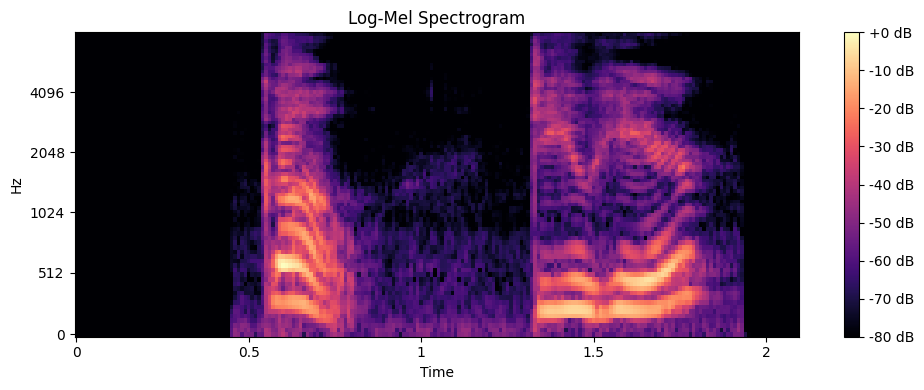

In [7]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    log_mel_spec,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

manifest_path = "../data/librispeech/dev_clean_manifest.csv"
df = pd.read_csv(manifest_path)

df.head()


,audio_path,transcript,duration
0,../data/librispeech/LibriSpeech/dev-clean/1272...,MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CL...,5.855
1,../data/librispeech/LibriSpeech/dev-clean/1272...,NOR IS MISTER QUILTER'S MANNER LESS INTERESTIN...,4.815
2,../data/librispeech/LibriSpeech/dev-clean/1272...,HE TELLS US THAT AT THIS FESTIVE SEASON OF THE...,12.485
3,../data/librispeech/LibriSpeech/dev-clean/1272...,HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIG...,9.900
4,../data/librispeech/LibriSpeech/dev-clean/1272...,LINNELL'S PICTURES ARE A SORT OF UP GUARDS AND...,29.400


In [9]:
import numpy as np
from tqdm import tqdm

mel_sums = np.zeros(N_MELS)
mel_sq_sums = np.zeros(N_MELS)
frame_count = 0

for audio_path in tqdm(df["audio_path"]):
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)

    mel_sums += log_mel.sum(axis=1)
    mel_sq_sums += (log_mel ** 2).sum(axis=1)
    frame_count += log_mel.shape[1]

mel_mean = mel_sums / frame_count
mel_std = np.sqrt(mel_sq_sums / frame_count - mel_mean ** 2)

print("Mean shape:", mel_mean.shape)
print("Std shape:", mel_std.shape)


100%|██████████| 2703/2703 [00:11<00:00, 235.55it/s]

Mean shape: (80,)
Std shape: (80,)


In [10]:
norm_log_mel = (log_mel_spec - mel_mean[:, None]) / mel_std[:, None]

print("Normalized mean:", norm_log_mel.mean())
print("Normalized std:", norm_log_mel.std())


Normalized mean: -0.8236897857569622
Normalized std: 0.9568838077859546


In [11]:
all_norm_values = []

for audio_path in df["audio_path"][:100]:  # sample 100 files
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)
    norm = (log_mel - mel_mean[:, None]) / mel_std[:, None]
    all_norm_values.append(norm)

all_norm_values = np.concatenate(all_norm_values, axis=1)
print("Global mean:", all_norm_values.mean())
print("Global std:", all_norm_values.std())



Global mean: -0.0017387011717618242
Global std: 1.0379090922955256


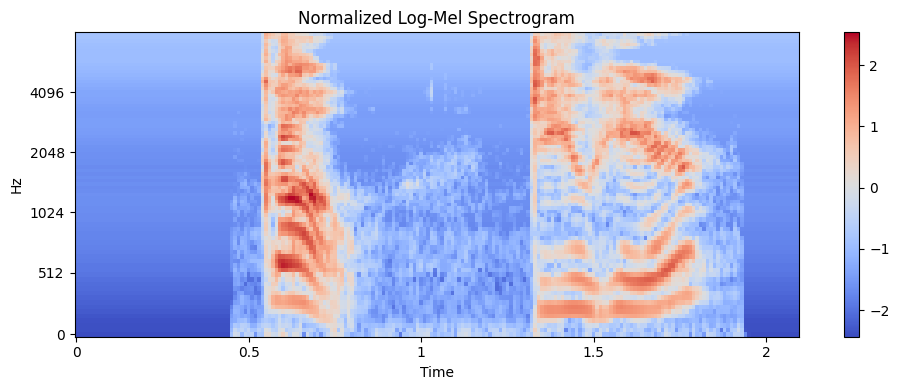

In [12]:
plt.figure(figsize=(10,4))
librosa.display.specshow(
    norm_log_mel,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar()
plt.title("Normalized Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

np.save("../data/librispeech/mel_mean.npy", mel_mean)
np.save("../data/librispeech/mel_std.npy", mel_std)


In [15]:
import sys
sys.path.append("..")

from src.audio import extract_logmel_normalized
feat = extract_logmel_normalized(
    "../data/librispeech/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"
)
print(feat.shape)


(80, 210)
